In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
pd.set_option("max_columns", None)
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
reviews = pd.read_csv("./Data/reviews.csv/reviews.csv")
listings = pd.read_csv("./Data/listings.csv/listings.csv")
summary_reviews = pd.read_csv("./Data/summary_reviews.csv")
summary_listings = pd.read_csv("./Data/summary_listings.csv")

In [2]:
new_reviews = pd.read_json(open("./Data/hongkong_listing_info/hongkong_listing_reviews.json", "r", encoding="utf8"))
new_listings = pd.read_json(open("./Data/hongkong_listing_info/hongkong_listing_details.json", "r", encoding="utf8"))

In [3]:
# "Price": converted from "price"
# https://stackoverflow.com/questions/42192323/convert-pandas-dataframe-to-float-with-commas-and-negative-numbers
listings["Price"] = listings.price.str.strip('$') # Why the scale of price is USD?
listings["Price"] = listings.Price.str.replace(',','')
listings["Price"] = pd.to_numeric(listings.Price,errors='coerce')
listings["Price"].describe()

# "Host_Since": converted from "host_since"
# https://chrisalbon.com/python/basics/strings_to_datetime/
from datetime import datetime, timedelta
listings["Host_Since"] = pd.to_datetime(listings["host_since"])

# "Listing_Age"
# https://stackoverflow.com/questions/42521107/python-pandas-find-number-of-years-between-two-dates
listings["today"] = pd.to_datetime("2019-09-20")
listings["Hosting_Age"] = np.round(((listings["today"]- listings["Host_Since"])/timedelta(days=365)),2)

# "Host_Since_Year": Extracted from "Host_Since"
# https://stackoverflow.com/questions/30405413/python-pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not/33757291
listings["Host_Since_Year"] = listings["Host_Since"].dt.year

# "Host_Since_Year_Month": Extracted from "Host_Since"
# https://datatofish.com/concatenate-values-python/
listings["Host_Since_Year_Month"] = listings["Host_Since"].astype('datetime64[M]')
listings["Host_Since_Year_Month"] = pd.to_datetime(listings["Host_Since_Year_Month"])

In [4]:
listings["Host_Since_Year_Month"]

0       2010-07-01
1       2011-04-01
2       2010-11-01
3       2010-11-01
4       2011-06-01
           ...    
12622   2017-10-01
12623   2018-07-01
12624   2019-04-01
12625   2017-03-01
12626   2019-09-01
Name: Host_Since_Year_Month, Length: 12627, dtype: datetime64[ns]

In [5]:
# Calculate number of unique listings
print("Number of unique listings:",listings["id"].nunique())

Number of unique listings: 12627


In [6]:
# Calculate unique number of listings group by "neighbourhood_cleansed"
distric_listings = listings["id"].groupby(listings["neighbourhood_cleansed"]).nunique()
dis_listings = pd.DataFrame(distric_listings)

# Convert index of a pandas dataframe into a column 
# https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
dis_listings.reset_index(level=0, inplace=True) 
dis_listings.rename(columns={"id":"count","neighbourhood_cleansed":"district"})

district  count
0   Central & Western   2624
1             Eastern    398
2             Islands    538
3        Kowloon City    487
4          Kwai Tsing     43
5           Kwun Tong     68
6               North    272
7            Sai Kung    157
8             Sha Tin    119
9        Sham Shui Po    258
10           Southern    106
11             Tai Po     57
12          Tsuen Wan     75
13           Tuen Mun     55
14           Wan Chai   2348
15       Wong Tai Sin     26
16      Yau Tsim Mong   4740
17          Yuen Long    256

In [9]:
import plotly
from plotly.offline import iplot,init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
# Barchart of unique listings in each district
trace = go.Bar(
                x = dis_listings.neighbourhood_cleansed,
                y = dis_listings.id,
                name = "Num of listings",
                marker = dict(color = 'rgba(255, 14, 5, 1.0)'),
                text = dis_listings.neighbourhood_cleansed)

layout = go.Layout(xaxis= dict(zeroline=False),
                   yaxis= dict(title= 'Num of listings'),
                   barmode="group",# barmode="relative"
                   title = 'Number of Airbnb Hong Kong listings by district') 

# Convert trace(plotly.graph_objs._bar.Bar) to a list 
data = [trace] 
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [10]:
# Print the frequency of multi-listings
(listings["calculated_host_listings_count"]>1).value_counts()

True     8510
False    4117
Name: calculated_host_listings_count, dtype: int64

In [11]:
print("Number of unique hosts:",listings["host_id"].nunique())

Number of unique hosts: 5490


In [12]:
# Calculate number of unique hosts in different districts
district_hosts = listings["host_id"].groupby(listings["neighbourhood_cleansed"]).nunique()
dis_hosts = pd.DataFrame(district_hosts)
dis_hosts.reset_index(level=0,inplace=True)
dis_hosts.rename(columns={"host_id":"host_count",'neighbourhood_cleansed':"district"})


district  host_count
0   Central & Western        1910
1             Eastern         240
2             Islands         311
3        Kowloon City         210
4          Kwai Tsing          32
5           Kwun Tong          46
6               North         170
7            Sai Kung         120
8             Sha Tin          92
9        Sham Shui Po         119
10           Southern          88
11             Tai Po          44
12          Tsuen Wan          57
13           Tuen Mun          45
14           Wan Chai        1007
15       Wong Tai Sin          21
16      Yau Tsim Mong        1164
17          Yuen Long         143

In [13]:
# Plot bar chart of unique hosts by district
trace = go.Bar(x=dis_hosts.neighbourhood_cleansed,
               y=dis_hosts.host_id,
               marker=dict(color='rgba(255, 14, 5, 1.0)'),
               text=dis_hosts.neighbourhood_cleansed)
        
layout = go.Layout(xaxis= dict(zeroline=False),
                   yaxis= dict(title= 'Num of hosts',zeroline=False),
                   barmode="group",# barmode="relative"
                   title = 'Number of Airbnb Hong Kong hosts by district') 
                
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [14]:
# Calculate the number of listings each host have
host_listing = pd.DataFrame(listings["calculated_host_listings_count"].groupby(listings["host_id"]).count())
host_listing = host_listing.reset_index()
host_listing = host_listing.rename(columns={'calculated_host_listings_count':"number of listings owned"})
host_listing.sort_values(by="number of listings owned",ascending=False).head(10)

host_id  number of listings owned
710     7518056                       518
3609   97240131                       268
3958  122131447                       143
4150  138649185                       123
476     4584648                       111
1231   14861546                       102
3197   67709885                        95
2898   52473150                        72
4333  156409670                        67
262     2767794                        64

In [15]:
listings['property_type'].unique()

array(['Apartment', 'Townhouse', 'Guest suite', 'Condominium', 'Loft',
       'Bed and breakfast', 'Hostel', 'Hotel', 'House', 'Aparthotel',
       'Other', 'Earth house', 'Serviced apartment', 'Boutique hotel',
       'Boat', 'Bungalow', 'Tiny house', 'Guesthouse',
       'Pension (South Korea)', 'Igloo', 'Farm stay', 'Chalet', 'Villa',
       'Cottage', 'Treehouse', 'Nature lodge', 'Tent', 'Cabin',
       'Houseboat', 'Hut', 'Vacation home', 'Minsu (Taiwan)', 'Island',
       'Dorm', 'Campsite', 'Castle', 'Barn', 'Casa particular (Cuba)',
       'Kezhan (China)'], dtype=object)

In [16]:
top1_host = listings.host_id == 7518056
listings[top1_host].neighbourhood_cleansed.value_counts()

pd.DataFrame(listings[top1_host].groupby('neighbourhood_cleansed')['id'].nunique())

id
neighbourhood_cleansed     
Central & Western        44
Eastern                  10
Kowloon City             75
Sham Shui Po             12
Wan Chai                322
Yau Tsim Mong            55

In [17]:
pd.DataFrame(listings[top1_host].groupby('property_type')['id'].nunique())

id
property_type          
Apartment           515
Condominium           1
Serviced apartment    2

In [18]:
top2_host = listings.host_id == 97240131
listings[top2_host].neighbourhood_cleansed.value_counts()

pd.DataFrame(listings[top2_host].groupby('neighbourhood_cleansed')['id'].nunique())

id
neighbourhood_cleansed    
Central & Western       88
Eastern                 27
Kowloon City            11
Sham Shui Po            15
Wan Chai                73
Yau Tsim Mong           54

In [19]:
pd.DataFrame(listings[top2_host].groupby('property_type')['id'].nunique())

id
property_type     
Apartment      268

In [20]:
top3_host = listings.host_id == 122131447
listings[top3_host].neighbourhood_cleansed.value_counts()

pd.DataFrame(listings[top3_host].groupby('neighbourhood_cleansed')['id'].nunique())

id
neighbourhood_cleansed     
Kowloon City             33
Yau Tsim Mong           110

In [21]:
pd.DataFrame(listings[top3_host].groupby('property_type')['id'].nunique())

id
property_type         
Apartment           33
Condominium         30
Serviced apartment  80

In [24]:
# Generate new feature host_group representing which group the host is in according to the listings they own.
# https://datatofish.com/if-condition-in-pandas-dataframe/
# To combine filtering conditions in Pandas, use bitwise operators ('&' and '|') not pure Python ones ('and' and 'or')
host_listing.loc[host_listing.calculated_host_listings_count<2,"host_group"]="1"
host_listing.loc[(host_listing.calculated_host_listings_count>=2) & (host_listing.calculated_host_listings_count<5) ,"host_group"]="2-4"
host_listing.loc[(host_listing.calculated_host_listings_count>=5) & (host_listing.calculated_host_listings_count<10) ,"host_group"]="5-9"
host_listing.loc[(host_listing.calculated_host_listings_count>=10) & (host_listing.calculated_host_listings_count<20) ,"host_group"]="10-19"
host_listing.loc[(host_listing.calculated_host_listings_count>=20) & (host_listing.calculated_host_listings_count<30) ,"host_group"]="20-29"
host_listing.loc[(host_listing.calculated_host_listings_count>=30) & (host_listing.calculated_host_listings_count<40) ,"host_group"]="30-39"
host_listing.loc[(host_listing.calculated_host_listings_count>=40) & (host_listing.calculated_host_listings_count<50) ,"host_group"]="40-49"
host_listing.loc[(host_listing.calculated_host_listings_count>=50) & (host_listing.calculated_host_listings_count<100) ,"host_group"]="50-99"
host_listing.loc[(host_listing.calculated_host_listings_count>=100) & (host_listing.calculated_host_listings_count<=518) ,"host_group"]="100-518"

AttributeError: 'DataFrame' object has no attribute 'calculated_host_listings_count'

In [25]:
group = pd.DataFrame(host_listing["host_group"].value_counts())
group = group.reset_index()

trace = go.Bar(x=group.host_group,
               y=group["index"],
               marker=dict(color="orange"),
               orientation="h",
               name="Num of hosts",
               text=group["index"])

layout = go.Layout(title="Number of hosts in each listing number group",
                   xaxis=dict(title="Number of hosts"),
                   yaxis=dict(title="Group"))

data=[trace]
fig = go.Figure(data=data,layout=layout)
        
iplot(fig)

KeyError: 'host_group'

In [26]:
(host_listing["calculated_host_listings_count"]>1).value_counts()

KeyError: 'calculated_host_listings_count'

In [27]:
print("Number of superhosts",listings[listings["host_is_superhost"]=="t"]["host_id"].nunique())
print("Number of listings from superhosts",listings[listings["host_is_superhost"]=="t"]["id"].nunique())

Number of superhosts 692
Number of listings from superhosts 2174


In [28]:
super_listings=pd.DataFrame(listings[listings["host_is_superhost"]=="t"]["id"].groupby(listings.neighbourhood_cleansed).nunique())
super_listings=super_listings.reset_index()
nonsuper_listings=pd.DataFrame(listings[listings["host_is_superhost"]=="f"]["id"].groupby(listings.neighbourhood_cleansed).nunique())
nonsuper_listings=nonsuper_listings.reset_index()

In [30]:
super_listings

neighbourhood_cleansed   id
0       Central & Western  281
1                 Eastern   63
2                 Islands  100
3            Kowloon City  120
4              Kwai Tsing    3
5               Kwun Tong   18
6                   North   47
7                Sai Kung   38
8                 Sha Tin   21
9            Sham Shui Po   33
10               Southern   17
11                 Tai Po   15
12              Tsuen Wan    8
13               Tuen Mun    4
14               Wan Chai  609
15           Wong Tai Sin    6
16          Yau Tsim Mong  735
17              Yuen Long   56

In [31]:
nonsuper_listings

neighbourhood_cleansed    id
0       Central & Western  2342
1                 Eastern   335
2                 Islands   438
3            Kowloon City   367
4              Kwai Tsing    40
5               Kwun Tong    50
6                   North   225
7                Sai Kung   119
8                 Sha Tin    98
9            Sham Shui Po   225
10               Southern    89
11                 Tai Po    42
12              Tsuen Wan    67
13               Tuen Mun    51
14               Wan Chai  1738
15           Wong Tai Sin    20
16          Yau Tsim Mong  4005
17              Yuen Long   200

In [32]:
trace1 = go.Bar(x=list(super_listings.neighbourhood_cleansed),
                y=list(super_listings.id),
                name="super listings")
trace2 = go.Bar(x=list(nonsuper_listings.neighbourhood_cleansed),
                y=list(nonsuper_listings.id),
                name="unsuper listings")

data = [trace1,trace2]

layout = go.Layout(xaxis = dict(zeroline=False),
                   yaxis = dict(title="Num of listings"),
                   barmode = "stack",
                   title = "Distribution of super/unsuper listings by district in Airbnb Hong Kong")
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [33]:
print(listings["room_type"].nunique())
print(listings["room_type"].value_counts())

4
Entire home/apt    6100
Private room       5544
Shared room         607
Hotel room          376
Name: room_type, dtype: int64


In [34]:
# How do room type distribute in different districts?
dis_roomtype = listings["id"].groupby([listings["neighbourhood_cleansed"],listings["room_type"]]).nunique()
dis_roomtype = pd.DataFrame(dis_roomtype)
new_dis_roomtype = dis_roomtype.reset_index()
new_dis_roomtype.head()

neighbourhood_cleansed        room_type    id
0      Central & Western  Entire home/apt  1854
1      Central & Western       Hotel room    21
2      Central & Western     Private room   685
3      Central & Western      Shared room    64
4                Eastern  Entire home/apt   186

In [35]:
listings["room_type"].value_counts()

Entire home/apt    6100
Private room       5544
Shared room         607
Hotel room          376
Name: room_type, dtype: int64

In [36]:
# Pie chart of room type
trace = go.Pie(values=listings["room_type"].value_counts(),
               labels=["Entire home/apt","Private room","Shared room","Hotel room"])
layout = go.Layout(title="Percentage of room type in Airbnb Hong Kong")
fig = go.Figure([trace],layout)
iplot(fig)

In [37]:
# Plot a histogram of accommodates
trace = go.Histogram(x=listings["accommodates"],
                     marker=dict(color="#ff3399"))

layout = go.Layout(xaxis=dict(title="Accommodates"),
                   yaxis=dict(title="Num of accommodates"),
                   title="Histogram of accommodates")
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [38]:
a=listings[listings["room_type"]=='Entire home/apt']
b=listings[listings["room_type"]=='Private room']
# Plot a histogram of accommodates
trace = go.Histogram(x=a["accommodates"],
                     marker=dict(color="#ff3399"))

layout = go.Layout(xaxis=dict(title="Accommodates"),
                   yaxis=dict(title="Num of accommodates"),
                   title="Histogram of accommodates")
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [39]:
# Plot a histogram of bathrooms
trace = go.Histogram(x=listings["bathrooms"],
                     marker=dict(color="#ff9900"))

layout = go.Layout(xaxis=dict(title="Bathrooms"),
                   yaxis=dict(title="Num of bathrooms"),
                   title="Histogram of bathrooms")
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [40]:
# Divivde bathrooms into 2 groups, bathroom = 1 or bathroom >1
listings.loc[listings["bathrooms"]<1,"Bathroom"]="1-"
listings.loc[listings["bathrooms"]==1,"Bathroom"]="1"
listings.loc[listings["bathrooms"]>1,"Bathroom"]="1+"

In [41]:
listings["Bathroom"].value_counts()

1     10687
1+     1787
1-      148
Name: Bathroom, dtype: int64

In [42]:
# Plot a histogram of bathrooms
trace = go.Histogram(x=listings["bedrooms"],
                     marker=dict(color="#ff9900"))

layout = go.Layout(xaxis=dict(title="Bedrooms"),
                   yaxis=dict(title="Num of bedrooms"),
                   title="Histogram of bedrooms")
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [43]:
print("Description of availability",listings["availability_365"].describe())
print("Available more than half a year\n",(listings["availability_365"]>60).value_counts())

Description of availability count    12627.000000
mean       163.962065
std        146.408094
min          0.000000
25%          1.000000
50%        117.000000
75%        344.000000
max        365.000000
Name: availability_365, dtype: float64
Available more than half a year
 True     8343
False    4284
Name: availability_365, dtype: int64


In [44]:
# Draw a histogram to show the distribution of listing age
trace = go.Histogram(x=listings["Hosting_Age"],
                     xbins=dict(start=0,end=9,size=0.5),
                     marker=dict(color="gold"))
layout = go.Layout(xaxis=dict(title="Hosting_Age"),
                   yaxis=dict(title="Frequency"),
                   title="Distribution of Listing Age in Airbnb Hong Kong")
data=[trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [45]:
mean_age = pd.DataFrame(listings["Hosting_Age"].groupby(listings["neighbourhood_cleansed"]).mean())
mean_age = mean_age.reset_index()

In [46]:
# Plot bar chart of unique hosts by district
trace = go.Bar(x=mean_age["neighbourhood_cleansed"],
               y=mean_age["Hosting_Age"],
               marker=dict(color='pink'))
        
layout = go.Layout(xaxis= dict(zeroline=False),
                   yaxis= dict(title= 'Mean Age',zeroline=False),
                   barmode="group",# barmode="relative"
                   title = 'Mean Age of hosting by district') 
                
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [47]:
trace1 = go.Bar(x=new_dis_roomtype[new_dis_roomtype["room_type"]=="Entire home/apt"].neighbourhood_cleansed,
                y=new_dis_roomtype[new_dis_roomtype["room_type"]=="Entire home/apt"].id,
                name="Entire home/apt")
trace2 = go.Bar(x=new_dis_roomtype[new_dis_roomtype["room_type"]=="Private room"].neighbourhood_cleansed,
                y=new_dis_roomtype[new_dis_roomtype["room_type"]=="Private room"].id,
                name="Private room")
trace3 = go.Bar(x=new_dis_roomtype[new_dis_roomtype["room_type"]=="Shared room"].neighbourhood_cleansed,
                y=new_dis_roomtype[new_dis_roomtype["room_type"]=="Shared room"].id,
                name="Shared room")
trace4 = go.Bar(x=new_dis_roomtype[new_dis_roomtype["room_type"]=="Hotel room"].neighbourhood_cleansed,
                y=new_dis_roomtype[new_dis_roomtype["room_type"]=="Hotel room"].id,
                name="Hotel room")

data = [trace1,trace2,trace3,trace4]

layout = go.Layout(xaxis = dict(zeroline=False),
                   yaxis = dict(title="Num of listings"),
                   barmode = "stack",
                   title = "Distribution of room types by district in Airbnb Hong Kong")
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [48]:
# When is the earliest and latest listing in Beijing Airbnb data?
print(listings["Host_Since"].min())
print(listings["Host_Since"].max())

2009-10-07 00:00:00
2019-09-20 00:00:00


In [49]:
# Count unique numbers of listings Groupby "Host_Since_Year"
listings_year = pd.DataFrame(listings["id"].groupby(listings["Host_Since_Year"]).nunique())
listings_year = listings_year.reset_index()

# Compute Cumulative Sum by date (year)
# https://stackoverflow.com/questions/42691405/cumulative-sum-by-date-month
listings_year["year_cumsum"] = listings_year["id"].cumsum()

In [55]:
listings_year

Host_Since_Year    id  year_cumsum
0            2009.0     2            2
1            2010.0    33           35
2            2011.0   182          217
3            2012.0   660          877
4            2013.0  1589         2466
5            2014.0  1579         4045
6            2015.0  2374         6419
7            2016.0  1999         8418
8            2017.0  1764        10182
9            2018.0  1382        11564
10           2019.0  1061        12625

In [50]:
# Draw a line to show the number of increased listings vs years since 2010
trace = go.Scatter(x=listings_year["Host_Since_Year"],
                   y=listings_year["id"],
                   mode = "lines+markers",
                   name="Num of listings",
                   marker = dict(color = "blue"),
                   text= listings_year.Host_Since_Year)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of listings",zeroline=False,),
                   title="Number of new listings in each year since 2009 in Airbnb Hong Kong")
data=[trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [51]:
# Calculate number of listings in each month period
listings_month = pd.DataFrame(listings["id"].groupby(listings["Host_Since_Year_Month"]).nunique())
listings_month = listings_month.reset_index()
listings_month["month_cumsum"] = listings_month["id"].cumsum()

In [52]:
listings_month["Host_Since_Year_Month"][1]

Timestamp('2009-12-01 00:00:00')

In [53]:
# Draw a line to show the increased number of listings vs months since 2010-08
trace = go.Scatter(x=listings_month["Host_Since_Year_Month"],
                   y=listings_month["id"],
                   mode = "lines+markers",
                   name="Num of new listings",
                   marker = dict(color = 'purple'))

layout = go.Layout(xaxis=dict(title="Year-Month",zeroline=False),
                   yaxis=dict(title="Num of new listings",zeroline=False,),
                   title="Number of new listings in each month for Airbnb Hong Kong")
data=[trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [54]:
# Draw a line to show the number of accumulative listings vs years since 2010
trace = go.Scatter(x=listings_year["Host_Since_Year"],
                   y=listings_year["year_cumsum"],
                   mode = "lines+markers",
                   name="Num of listings",
                   marker = dict(color = "rgba(255, 112, 2, 1.0)"),
                   text= listings_year.Host_Since_Year)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Accumulative sum of listings",zeroline=False,),
                   title="Accumulative number of listings year by year since 2009 in Airbnb Hong Kong")
data=[trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [151]:
# Draw 2 lines to show the number of new listings and totoal number of listings vs years since 2010
trace1 = go.Scatter(x=listings_year["Host_Since_Year"],
                   y=listings_year["id"],
                   mode = "lines+markers",
                   name="Num of new listings",
                   marker = dict(color = "blue"),
                   text= listings_year.Host_Since_Year)

trace2 = go.Scatter(x=listings_year["Host_Since_Year"],
                   y=listings_year["year_cumsum"],
                   mode = "lines+markers",
                   name="Num of total listings",
                   marker=dict(color="rgba(255, 112, 2, 1.0)"),
                   text= listings_year.Host_Since_Year)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of listings",zeroline=False,),
                   title="Number of new listings and total listings since 2009 in Airbnb Hong Kong")
data=[trace1,trace2]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [152]:
# Count unique numbers of listings Groupby "Host_Since_Year" and "neighbourhood_cleansed".
# https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_groups/
listings_dis_year = pd.DataFrame(listings["id"].groupby([listings["neighbourhood_cleansed"],listings["Host_Since_Year"]]).nunique())
listings_dis_year = listings_dis_year.reset_index()

In [158]:


dis =  listings_dis_year["neighbourhood_cleansed"].unique()

def traces(a,df,column,colors):
    data = []
    for i in range(len(a)):
        trace = go.Scatter(x=df[df["neighbourhood_cleansed"]==a[i]].Host_Since_Year,
                           y=df[df["neighbourhood_cleansed"]==a[i]][column],
                           mode = "lines+markers",
                           name=a[i],
                           )
        data.append(trace)
    return data

data =traces(dis,listings_dis_year,"id",colors)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of listings",zeroline=False,),
                   title="Number of new listings by Year and by District in Airbnb Hong Kong")

fig = go.Figure(data=data,layout=layout)
iplot(fig)


In [157]:
print("Number of unique reviews:",reviews["id"].nunique())
print("Number of unique listings with:",reviews["listing_id"].nunique())

Number of unique reviews: 262192
Number of unique listings with: 8687


In [161]:
# "date": converted from str type "date" to datetime type "date"
# https://chrisalbon.com/python/basics/strings_to_datetime/
from datetime import datetime, timedelta
reviews["Date"] = pd.to_datetime(reviews["date"])

In [162]:
# "date_year": Extracted from "date"
# https://stackoverflow.com/questions/30405413/python-pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not/33757291
reviews["date_year"] = reviews["Date"].dt.year

# "date_year_month": Extracted from "date"
# https://datatofish.com/concatenate-values-python/
reviews["date_year_month"] = (reviews["Date"].dt.year).map(str) + "-" + (reviews["Date"].dt.month).map(str)
reviews["date_year_month"] = pd.to_datetime(reviews["date_year_month"])

In [166]:
# Count unique numbers of reviews Groupby "date_year"
review_year = pd.DataFrame(reviews["id"].groupby(reviews["date_year"]).nunique())
review_year = review_year.reset_index()

# Compute Cumulative Sum by date (year)
# https://stackoverflow.com/questions/42691405/cumulative-sum-by-date-month
review_year["year_cumsum"] = review_year["id"].cumsum()
review_year.rename(columns={"id":"count","year_cumsum":"year_sum"})

date_year  count  year_sum
0       2011     91        91
1       2012    552       643
2       2013   1855      2498
3       2014   5160      7658
4       2015  13287     20945
5       2016  29013     49958
6       2017  53471    103429
7       2018  83631    187060
8       2019  75132    262192

In [168]:
# Draw a line to show the number of new reviews by year since 2010
trace = go.Scatter(x=review_year["date_year"],
                   y=review_year["id"],
                   mode = "lines+markers",
                   name="Num of reviews",
                   marker = dict(color = "#ff8c66"),
                   text= review_year.date_year)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of reviews",zeroline=False,),
                   title="Number of new reviews in each year since 2011 in Airbnb Hong Kong")
data=[trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [169]:
# Let's combine listing supply and demand together
trace1 = go.Scatter(x=review_year["date_year"],
                   y=review_year["id"],
                   mode = "lines+markers",
                   name="Num of new reviews",
                   marker = dict(color = "#ff8c66"),
                   text= review_year.date_year)

trace2 = go.Scatter(x=listings_year["Host_Since_Year"],
                   y=listings_year["id"],
                   mode = "lines+markers",
                   name="Num of new listings",
                   marker = dict(color = "blue"),
                   text= listings_year.Host_Since_Year)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of reviews",zeroline=False,),
                   title="Number of new reviews vs listings in each year since 2010 in Airbnb Beijing")

data=[trace1,trace2]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [171]:
# Let's combine total listing supply and demand together
trace1 = go.Scatter(x=review_year["date_year"],
                   y=review_year["year_cumsum"],
                   mode = "lines+markers",
                   name="Num of new reviews",
                   marker = dict(color = "#cc33ff"),
                   text= review_year.date_year)

trace2 = go.Scatter(x=listings_year["Host_Since_Year"],
                   y=listings_year["year_cumsum"],
                   mode = "lines+markers",
                   name="Num of new listings",
                   marker = dict(color = "blue"),
                   text= listings_year.Host_Since_Year)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of reviews",zeroline=False,),
                   title="Number of total reviews vs listings until each year since 2009 in Airbnb Hong Kong")

data=[trace1,trace2]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [173]:
# Break down into months
# Count unique numbers of reviews Groupby "date_year_month"
review_month = pd.DataFrame(reviews["id"].groupby(reviews["date_year_month"]).nunique())
review_month = review_month.reset_index()

# Compute Cumulative Sum by date (year)
# https://stackoverflow.com/questions/42691405/cumulative-sum-by-date-month
review_month["month_cumsum"] = review_month["id"].cumsum()


In [175]:
# Draw a line to show the number of new reviews by month since 2010
trace = go.Scatter(x=review_month["date_year_month"],
                   y=review_month["id"],
                   mode = "lines+markers",
                   name="Num of reviews",
                   marker = dict(color = "#33cc33"),
                   text= review_month.date_year_month)

layout = go.Layout(xaxis=dict(title="Year",zeroline=False),
                   yaxis=dict(title="Num of reviews",zeroline=False,),
                   title="Number of new reviews in each month since 2009 in Airbnb Hong Kong")
data=[trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [177]:
print("Description of Price\n",listings["Price"].describe())
print(listings["Price"].isnull().sum())

Description of Price
 count    12627.000000
mean       760.615031
std       1701.595702
min          0.000000
25%        329.000000
50%        501.000000
75%        853.000000
max      78282.000000
Name: Price, dtype: float64
0


In [179]:
# Plot a histogram of price
trace = go.Histogram(x=listings["Price"],
                     marker=dict(color="green"))

layout = go.Layout(xaxis=dict(title="Price"),
                   yaxis=dict(title="Num of Listings"),
                   title="Histogram of Price")
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [182]:
# Draw a box plot showing the distribution of room price in each district
trace = go.Box(x=listings.neighbourhood_cleansed,
               y=listings.Price,
               name="Price",
               marker = dict(color = 'rgb(122, 12, 240)'))

layout = go.Layout(xaxis=dict(zeroline=False),
                   yaxis=dict(title="Price(HKD)"),
                   title="Box chart of room price by district in Airbnb Hong Kong")

data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [184]:
# Draw a box plot showing the distribution of room price in each type
trace = go.Box(x=listings.room_type,
               y=listings.Price,
               name="Price")

layout = go.Layout(xaxis=dict(zeroline=False),
                   yaxis=dict(title="Price(¥)"),
                   title="Box chart of room price by room type in Airbnb Hong Kong")

data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [185]:
price = listings[["id","neighbourhood_cleansed","host_is_superhost",
                  "room_type","accommodates","bathrooms","bedrooms","beds",
                  "review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location",
                  "review_scores_value",
                  "number_of_reviews","Price"]]
price.head()

id neighbourhood_cleansed host_is_superhost        room_type  \
0   69074      Central & Western                 f  Entire home/apt   
1  101765                Islands                 t  Entire home/apt   
2  103760      Central & Western                 f  Entire home/apt   
3  132773      Central & Western                 f  Entire home/apt   
4  133390      Central & Western                 f  Entire home/apt   

   accommodates  bathrooms  bedrooms  beds  review_scores_rating  \
0             3        1.0       1.0   2.0                  97.0   
1             1        1.0       1.0   1.0                  94.0   
2             6        1.0       2.0   3.0                  89.0   
3             6        1.0       2.0   3.0                  92.0   
4             2        1.0       1.0   1.0                  97.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                        9.0                   10.0   
1                    10.0                        9.0                    9.0   
2                     9.0                        9.0                   10.0   
3                     9.0                        9.0                    9.0   
4                    10.0                        9.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                  9.0   
1                         10.0                    10.0                  9.0   
2                         10.0                    10.0                  9.0   
3                          9.0                     9.0                  9.0   
4                         10.0                    10.0                 10.0   

   number_of_reviews   Price  
0                132  1409.0  
1                 11   431.0  
2                262   853.0  
3                263  1057.0  
4                 27   939.0

In [186]:
import plotly.figure_factory as ff

price_score = price.corr()
figure = ff.create_annotated_heatmap(
    z=price_score.values,
    x=list(price_score.columns),
    y=list(price_score.index),
    annotation_text=price_score.round(2).values,
    showscale=True)
iplot(figure)

In [187]:
df = listings[["calculated_host_listings_count","Price"]]
df.loc[listings["calculated_host_listings_count"]>1,"group"] = "Multi-listing"
df.loc[listings["calculated_host_listings_count"]==1,"group"] = "Mono-listing"

In [190]:
scores = listings[["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","host_total_listings_count","Price","Hosting_Age"]]
scores.head()

review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  97.0                    10.0                        9.0   
1                  94.0                    10.0                        9.0   
2                  89.0                     9.0                        9.0   
3                  92.0                     9.0                        9.0   
4                  97.0                    10.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                    9.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                    9.0                          9.0                     9.0   
4                   10.0                         10.0                    10.0   

   review_scores_value  host_total_listings_count   Price  Hosting_Age  
0                  9.0                        2.0  1409.0         9.21  
1                  9.0                        1.0   431.0         8.41  
2                  9.0                       12.0   853.0         8.81  
3                  9.0                       12.0  1057.0         8.81  
4                 10.0                        1.0   939.0         8.31

In [192]:
# Draw a box plot showing the distribution of room price in each district
trace = go.Box(x=listings.neighbourhood_cleansed,
               y=listings.review_scores_rating,
               name="Review Score",
               marker = dict(color = "#ff3399"))

layout = go.Layout(xaxis=dict(zeroline=False),
                   yaxis=dict(title="Review Score"),
                   title="Box chart of Review Score by district in Airbnb Beijing")

data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [193]:
# Draw a box plot showing the distribution of room price in each district
trace = go.Scatter(x=listings.number_of_reviews,
                   y=listings.review_scores_rating,
                   name="Review Score",
                   mode="markers",
                   marker = dict(color = "#ff3399"))

layout = go.Layout(xaxis=dict(title="Number of Reviews"),
                   yaxis=dict(title="Review Score"),
                   title="Scatter of Review Score vs Number of Reviews")

data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [194]:
# Draw a box plot showing the distribution of room price in each district
trace = go.Scatter(x=listings.Price,
                   y=listings.review_scores_rating,
                   name="Price",
                   mode="markers",
                   marker = dict(color="#339933"))

layout = go.Layout(xaxis=dict(zeroline=False),
                   yaxis=dict(title="Price"),
                   title="Scatter of Review Score vs Price")

data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [52]:
new_listings.head()

id                   host_name   member_since  \
0  10133631                        Ming   October 2014   
1  11246705                       Kylie  February 2016   
2   5767728                    Michelle     March 2015   
3   9911088                          Jj    August 2014   
4   8768949  Atlas Hostel & Backpackers   October 2015   

                                           amenities  \
0                                               None   
1  In my NEW studio you can find: \n1 comfortable...   
2  Amenities: \n. A queen size bed \n. A Tatami b...   
3  House main door is equipped with pass-code loc...   
4  By booking a bed space in the Bunk Dorm Room, ...   

                                               notes  \
0                                               None   
1  Official check in time is 2 pm, check out time...   
2  If you go from airport you can choose the airp...   
3  There will be a 24 hours security at the build...   
4  Atlas Hostel is centrally-located in Tsim Sha ...   

                                             transit  \
0                                               None   
1  Tsim Sha Tsui is the best place in Hong Kong. ...   
2  Tsim Sha Tsui is the hub for transportation in...   
3  Within mins walk to reach all kinds of local a...   
4  When you stay at Atlas Hostel, you have plenty...   

                                               space  \
0                                               None   
1  Welcome! Hope you like my apartment! :)\nMy ne...   
2  This sweet apartment is newly renovated in Jun...   
3  The room is furnished with one double bed (115...   
4  Welcome backpackers, wanderers, & explorers! \...   

                                         description  \
0  double bed room(140X200)near Jordan mtr statio...   
1  My peaceful apartment is about 300 sqft, renov...   
2  This cozy apartment is  renovated in June 2015...   
3  Welcome to my listing!\n\nClean n cozy private...   
4  Whether you’re a seasoned backpacker or a firs...   

                               neighborhood_overview  neighborhood_id  \
0                                               None            181.0   
1  Some information about the location:\n•It's lo...            181.0   
2  There are many shopping malls /restaurants  ar...            181.0   
3  Located at the heart of Tim Sha Tsui area, 1 m...            181.0   
4  Located on Nathan Rd, directly across from Kow...            181.0   

   review_scores_rating                                            summary  \
0                    90  double bed room(140X200)near Jordan mtr statio...   
1                    91  My peaceful apartment is about 300 sqft, renov...   
2                    88  This cozy apartment is  renovated in June 2015...   
3                    93  Welcome to my listing!\n\nClean n cozy private...   
4                    93  Whether you’re a seasoned backpacker or a firs...   

   review_scores_accuracy  Accuracy_localized  review_scores_communication  \
0                       9                 4.7                           10   
1                       9                 4.8                           10   
2                       9                 4.6                            9   
3                       9                 4.8                            9   
4                       9                 4.7                            9   

   Communication_localized  review_scores_cleanliness  Cleanliness_localized  \
0                      4.8                          9                    4.5   
1                      4.8                          9                    4.8   
2                      4.7                          9                    4.4   
3                      4.8                         10                    4.8   
4                      4.7                          9                    4.7   

   review_scores_location  Location_localized  review_scores_checkin  \
0                      10                 4.8

In [53]:
listings.head()

id                          listing_url       scrape_id last_scraped  \
0   69074   https://www.airbnb.com/rooms/69074  20190920160325   2019-09-20   
1  101765  https://www.airbnb.com/rooms/101765  20190920160325   2019-09-20   
2  103760  https://www.airbnb.com/rooms/103760  20190920160325   2019-09-20   
3  132773  https://www.airbnb.com/rooms/132773  20190920160325   2019-09-20   
4  133390  https://www.airbnb.com/rooms/133390  20190920160325   2019-09-20   

                                              name  \
0  Beautiful oasis of plants & art @ best location   
1      Lamma Island flat 2min walk from the beach!   
2    Central Centre 5 min walk to/from Central MTR   
3               Fabulous 2 Bdrm Aprt Open kitchen    
4                   Soho, Hong Kong 1 bedroom flat   

                                             summary  \
0  An ideal Hong location any visitor--hip withou...   
1  My place is close to Beaches, great little sho...   
2  Located right in the heart of Central, this 2 ...   
3  Nicely decorated, spacious 2 bedroom apartment...   
4  My cozy one bedroom apartment is located in th...   

                                               space  \
0  Filled with plants and art, this one bedroom u...   
1  Entire home with single firm bed and a closet ...   
2  You really can't ask for a better location.  I...   
3  This is a large 2 Bedroom apartment that is ne...   
4  My one-bedroom apartment (about 500 sq. feet) ...   

                                         description experiences_offered  \
0  An ideal Hong location any visitor--hip withou...                none   
1  My place is close to Beaches, great little sho...                none   
2  Located right in the heart of Central, this 2 ...                none   
3  Nicely decorated, spacious 2 bedroom apartment...                none   
4  My cozy one bedroom apartment is located in th...                none   

                               neighborhood_overview  \
0  In the upper part of trendy, hip Sheung Wan, w...   
1  Lamma Island is known as Hippie Island. The re...   
2                                                NaN   
3  The Sheung Wan neighbourhood is ever changing ...   
4  Soho in Central is right in the middle of all ...   

                                               notes  \
0                                                NaN   
1  The village house is about a 15min walk from t...   
2  Once you arrive in Hong Kong, everything is qu...   
3  Once you arrive in Hong Kong, everything is qu...   
4                                                NaN   

                                             transit  \
0  Buses pass often along Hollywood Road and taxi...   
1  Bike or foot. Ferries go to either Central or ...   
2  Central MTR is 5 min walk away. Trams, buses, ...   
3  The Sheung Wan MTR station is but 8 min walkin...   
4  Hong Kong public transport is incredible. The ...   

                                              access  \
0    All access, except one section of the wardrobe.   
1  Guests have access to the private bedroom, a b...   
2  Guests have access to: - FREE WiFi - Cable TV ...   
3  Guests have access to: - FREE WiFi - Cable TV ...   
4                                                NaN   

                                         interaction  \
0  If a guest is staying there, I am likely abroa...   
1  Happy to answer any questions about the area a...   
2  As much as possible or invisible if you want. ...   
3  As much as possible or invisible if you want. ...   
4                                                NaN   

                                         house_rules  thumbnail_url  \
0  Everything to make your stay as comfortable as...            NaN   
1                                                NaN            NaN   
2  This is a Strictly NON SMOKING Flat. UPON ARRI...            NaN   
3  This is a Strictly NON SMOKING Flat. UPON ARRI...            NaN   
4  No smoking inside (there is a roo

In [54]:
room_type_df = listings.groupby('room_type').id.count()
room_type_df = room_type_df.reset_index()
room_type_df = room_type_df.rename(columns={'id': 'number_of_listings'})
room_type_df

room_type  number_of_listings
0  Entire home/apt                6100
1       Hotel room                 376
2     Private room                5544
3      Shared room                 607

In [55]:
df = listings.copy()

In [56]:
df.fillna(0, inplace=True)

# Meng-ekstrak kolom price
price = df['price']
prices = []

# Konversi string ke float
for p in price:
    p = float(p[1:].replace(',', ''))
    prices.append(p)
    
# Ganti kolom price dengan yang baru
df['price'] = prices

# Mengambil data yang tidak kosong
df = df[df.bathrooms > 0]
df = df[df.bedrooms > 0]
df = df[df.beds > 0]
df = df[df.price > 0]
df = df[df.review_scores_rating > 0]
df = df[df.reviews_per_month > 0]
df = df[df.accommodates > 0]

# Menampilkan header
df.head()

id                          listing_url       scrape_id last_scraped  \
0   69074   https://www.airbnb.com/rooms/69074  20190920160325   2019-09-20   
1  101765  https://www.airbnb.com/rooms/101765  20190920160325   2019-09-20   
2  103760  https://www.airbnb.com/rooms/103760  20190920160325   2019-09-20   
3  132773  https://www.airbnb.com/rooms/132773  20190920160325   2019-09-20   
4  133390  https://www.airbnb.com/rooms/133390  20190920160325   2019-09-20   

                                              name  \
0  Beautiful oasis of plants & art @ best location   
1      Lamma Island flat 2min walk from the beach!   
2    Central Centre 5 min walk to/from Central MTR   
3               Fabulous 2 Bdrm Aprt Open kitchen    
4                   Soho, Hong Kong 1 bedroom flat   

                                             summary  \
0  An ideal Hong location any visitor--hip withou...   
1  My place is close to Beaches, great little sho...   
2  Located right in the heart of Central, this 2 ...   
3  Nicely decorated, spacious 2 bedroom apartment...   
4  My cozy one bedroom apartment is located in th...   

                                               space  \
0  Filled with plants and art, this one bedroom u...   
1  Entire home with single firm bed and a closet ...   
2  You really can't ask for a better location.  I...   
3  This is a large 2 Bedroom apartment that is ne...   
4  My one-bedroom apartment (about 500 sq. feet) ...   

                                         description experiences_offered  \
0  An ideal Hong location any visitor--hip withou...                none   
1  My place is close to Beaches, great little sho...                none   
2  Located right in the heart of Central, this 2 ...                none   
3  Nicely decorated, spacious 2 bedroom apartment...                none   
4  My cozy one bedroom apartment is located in th...                none   

                               neighborhood_overview  \
0  In the upper part of trendy, hip Sheung Wan, w...   
1  Lamma Island is known as Hippie Island. The re...   
2                                                  0   
3  The Sheung Wan neighbourhood is ever changing ...   
4  Soho in Central is right in the middle of all ...   

                                               notes  \
0                                                  0   
1  The village house is about a 15min walk from t...   
2  Once you arrive in Hong Kong, everything is qu...   
3  Once you arrive in Hong Kong, everything is qu...   
4                                                  0   

                                             transit  \
0  Buses pass often along Hollywood Road and taxi...   
1  Bike or foot. Ferries go to either Central or ...   
2  Central MTR is 5 min walk away. Trams, buses, ...   
3  The Sheung Wan MTR station is but 8 min walkin...   
4  Hong Kong public transport is incredible. The ...   

                                              access  \
0    All access, except one section of the wardrobe.   
1  Guests have access to the private bedroom, a b...   
2  Guests have access to: - FREE WiFi - Cable TV ...   
3  Guests have access to: - FREE WiFi - Cable TV ...   
4                                                  0   

                                         interaction  \
0  If a guest is staying there, I am likely abroa...   
1  Happy to answer any questions about the area a...   
2  As much as possible or invisible if you want. ...   
3  As much as possible or invisible if you want. ...   
4                                                  0   

                                         house_rules  thumbnail_url  \
0  Everything to make your stay as comfortable as...            0.0   
1                                                  0            0.0   
2  This is a Strictly NON SMOKING Flat. UPON ARRI...            0.0   
3  This is a Strictly NON SMOKING Flat. UPON ARRI...            0.0   
4  No smoking inside (there is a roo

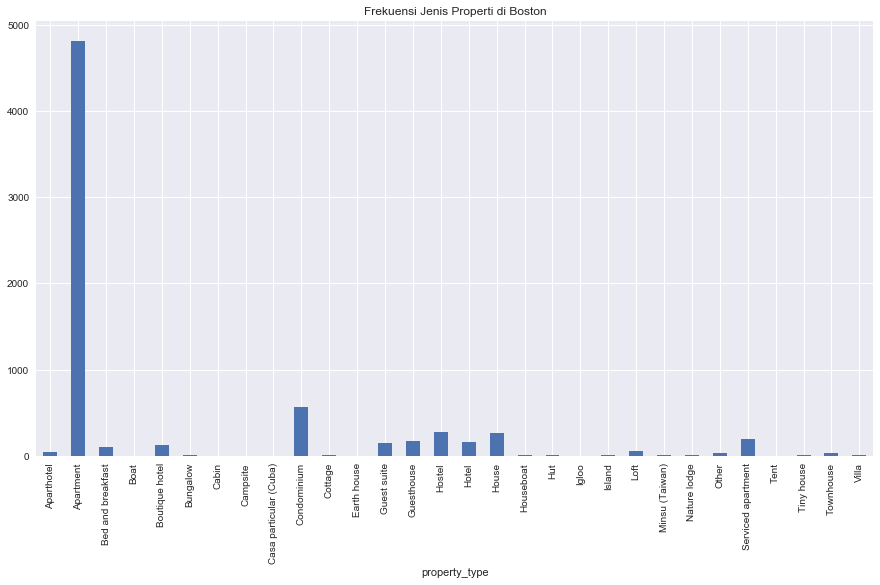

In [57]:

%matplotlib inline

# Meng-import library
import matplotlib
import matplotlib.pyplot as plt

# Menmbuat group dataframe dari tipe properti
property_type_df = df.groupby('property_type').id.count()
property_type_df = property_type_df.reset_index()
property_type_df = property_type_df.rename(columns={'id': 'number_of_listings'})

objects = property_type_df['property_type']
y_pos = property_type_df['number_of_listings']

# Plot ke diagram bar
property_type_df.plot.bar(x = 'property_type',
                          y = 'number_of_listings',
                          figsize = (15, 8),
                          title = 'Frekuensi Jenis Properti di Boston',
                          legend = False)

# Memberi label
plt.xlabel = 'Tipe Properti'
plt.ylabel = 'Frekuensi'



In [58]:
room_property_df = df.groupby(['property_type', 'room_type']).price.mean()
room_property_df = room_property_df.reset_index()
room_property_df = room_property_df.sort_values('price', ascending=[0])
room_property_df

property_type        room_type        price
59               Villa  Entire home/apt  5474.250000
36           Houseboat  Entire home/apt  2839.166667
24          Guesthouse  Entire home/apt  2678.333333
56           Townhouse  Entire home/apt  2060.700000
46               Other     Private room  1836.821429
..                 ...              ...          ...
10      Boutique hotel      Shared room   180.000000
51  Serviced apartment      Shared room   164.000000
42                Loft      Shared room   149.000000
52                Tent  Entire home/apt   149.000000
55          Tiny house      Shared room    86.000000

[61 rows x 3 columns]

In [59]:
import re

calendarDF=pd.read_csv("./Data/calendar.csv/calendar.csv")

#replacing NaN values with 0
calendarDF.fillna(0, inplace=True)
calendarDF = calendarDF[calendarDF.price != 0]

#Extracting prices from the table
price = calendarDF['price']
prices=[]

for p in price:
    p = re.sub('[^0-9.]+','', p)
    prices.append(float(p))
    
#replace the price column with the new column
calendarDF['price']=prices

calendarDF = calendarDF[calendarDF.price >= 0]

#separating date column into day month and year
calendarDF['Year'],calendarDF['Month'],calendarDF['Day']=calendarDF['date'].str.split('-',2).str
calendarDF.head()

listing_id        date available   price adjusted_price  minimum_nights  \
0       69074  2019-09-20         f  1104.0      $1,104.00               3   
1       69074  2019-09-21         f  1104.0      $1,104.00               3   
2       69074  2019-09-22         f  1065.0      $1,065.00               3   
3       69074  2019-09-23         f  1073.0      $1,073.00               3   
4       69074  2019-09-24         f  1300.0      $1,300.00               3   

   maximum_nights  Year Month Day  
0             365  2019    09  20  
1             365  2019    09  21  
2             365  2019    09  22  
3             365  2019    09  23  
4             365  2019    09  24

In [60]:
yearDF=calendarDF.groupby(['Year','Month']).price.mean()
yearDF=yearDF.reset_index()
yearDF=yearDF.rename(columns={'price':'average_Price'})
yearDF['year-Month']=yearDF['Year'].map(str) + "-" + yearDF['Month'].map(str)
yearDF.head()

Year Month  average_Price year-Month
0  2019    09     669.601748    2019-09
1  2019    10     724.602375    2019-10
2  2019    11     749.213780    2019-11
3  2019    12     822.309904    2019-12
4  2020    01     830.304174    2020-01

TypeError: 'str' object is not callable

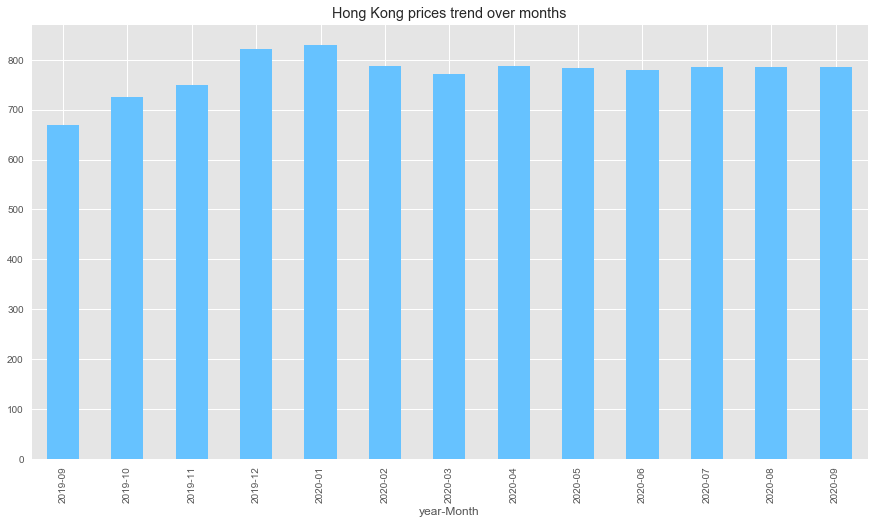

In [61]:
# visualizing the trend of year/Month and average prices of the listing

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

objects = yearDF['year-Month']
y_pos = yearDF['average_Price']

yearDF.plot(kind='bar', 
           x='year-Month',
           y='average_Price',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = 'Hong Kong prices trend over months', 
           legend = False)
plt.ylabel('Average Price')

In [68]:
#getting day name from date data and holidays

from datetime import date
import datetime
import calendar
from workalendar.asia import HongKong


calendarDF.fillna(0, inplace=True)
hk = HongKong().holidays(2020)
hk_holidays = dict((k[0],k[1]) for k in hk)

calendarDF['day_Name']='default'
calendarDF['holiday']='False'
calendarDF['hk_holidays_name']='working'
for index,row in calendarDF.iterrows():
    sdate = datetime.date(int(row['Year']),int(row['Month']),int(row['Day']))
    vall=date(int(row['Year']),int(row['Month']),int(row['Day'])) in hk_holidays
    calendarDF.set_value(index,'day_Name',calendar.day_name[sdate.weekday()])
    calendarDF.set_value(index,'holiday',vall)
    calendarDF.set_value(index,'hk_holidays_name',hk_holidays.get(sdate))
calendarDF.head()

listing_id        date available   price adjusted_price  minimum_nights  \
0       69074  2019-09-20         f  1104.0      $1,104.00               3   
1       69074  2019-09-21         f  1104.0      $1,104.00               3   
2       69074  2019-09-22         f  1065.0      $1,065.00               3   
3       69074  2019-09-23         f  1073.0      $1,073.00               3   
4       69074  2019-09-24         f  1300.0      $1,300.00               3   

   maximum_nights  Year Month Day  day_Name holiday us_holidays_name  \
0             365  2019    09  20    Friday   False          working   
1             365  2019    09  21  Saturday   False          working   
2             365  2019    09  22    Sunday   False          working   
3             365  2019    09  23    Monday   False          working   
4             365  2019    09  24   Tuesday   False          working   

  hk_holidays_name  
0             None  
1             None  
2             None  
3             None  
4             None

In [69]:
#calculating Average price for each day

dayDF=calendarDF.groupby('day_Name').price.mean()
dayDF=dayDF.reset_index()
dayDF['day_num']=0

for index,row in dayDF.iterrows():
    if row['day_Name']=='Monday':
        dayDF.set_value(index,'day_num',1)
    if row['day_Name']=='Tuesday':
        dayDF.set_value(index,'day_num',2)
    if row['day_Name']=='Wednesday':
        dayDF.set_value(index,'day_num',3)
    if row['day_Name']=='Thursday':
        dayDF.set_value(index,'day_num',4)
    if row['day_Name']=='Friday':
        dayDF.set_value(index,'day_num',5)
    if row['day_Name']=='Saturday':
        dayDF.set_value(index,'day_num',6)
    if row['day_Name']=='Sunday':
        dayDF.set_value(index,'day_num',7)
dayDF=dayDF.sort_values('day_num',ascending=[1])
dayDF=dayDF.rename(columns={'price':'Average_Price'})
dayDF

day_Name  Average_Price  day_num
1     Monday     769.282016        1
5    Tuesday     772.408450        2
6  Wednesday     770.831766        3
4   Thursday     770.090117        4
0     Friday     799.173143        5
2   Saturday     801.940027        6
3     Sunday     770.213665        7

In [71]:
#checking which holiday has maximum listings

holidayDF=calendarDF.groupby('hk_holidays_name').listing_id.count()
holidayDF=holidayDF.reset_index()
holidayDF=holidayDF.sort_values('listing_id',ascending=[0])
holidayDF

hk_holidays_name  listing_id
1           Chinese Lunar New Year shift       12627
2           Chinese Lunar New Year's Day       12627
8                               New year       12627
10  Second day of Chinese Lunar New Year       12627
11   Third day of Chinese Lunar New Year       12627
0                      Buddha's Birthday       12626
3                    Ching Ming Festival       12626
4                          Easter Monday       12626
5                        Easter Saturday       12626
6                            Good Friday       12626
7                             Labour Day       12626
9                  SAR Establishment Day       12626
12                      Tuen Ng Festival       12626

[Text(0, 0.5, 'Total Number of Listings'), Text(0.5, 0, 'HK Holidays Name')]

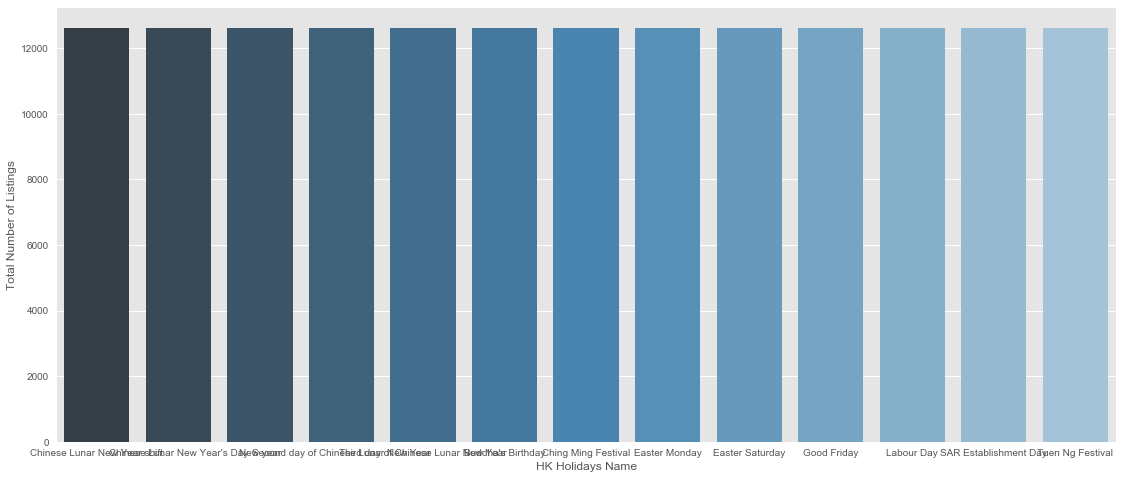

In [73]:
# visualizing the same
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(19,8))
ax = sns.barplot("hk_holidays_name", y="listing_id", data=holidayDF,palette="Blues_d")
ax.set(xlabel='HK Holidays Name', ylabel='Total Number of Listings')

[(datetime.date(2020, 1, 1), 'New year'),
 (datetime.date(2020, 1, 25), "Chinese Lunar New Year's Day"),
 (datetime.date(2020, 1, 26), 'Second day of Chinese Lunar New Year'),
 (datetime.date(2020, 1, 27), 'Second day of Chinese Lunar New Year shift'),
 (datetime.date(2020, 1, 27), 'Third day of Chinese Lunar New Year'),
 (datetime.date(2020, 1, 28), 'Chinese Lunar New Year shift'),
 (datetime.date(2020, 4, 4), 'Ching Ming Festival'),
 (datetime.date(2020, 4, 10), 'Good Friday'),
 (datetime.date(2020, 4, 11), 'Easter Saturday'),
 (datetime.date(2020, 4, 13), 'Easter Monday'),
 (datetime.date(2020, 4, 30), "Buddha's Birthday"),
 (datetime.date(2020, 5, 1), 'Labour Day'),
 (datetime.date(2020, 6, 25), 'Tuen Ng Festival'),
 (datetime.date(2020, 7, 1), 'SAR Establishment Day'),
 (datetime.date(2020, 10, 1), 'National Day'),
 (datetime.date(2020, 10, 2), 'Day After Mid-Autumn Festival'),
 (datetime.date(2020, 10, 25), 'Chung Yeung Festival'),
 (datetime.date(2020, 10, 26), 'Chung Yeung Fest

{datetime.date(2020, 1, 1): 'New year',
 datetime.date(2020, 1, 25): "Chinese Lunar New Year's Day",
 datetime.date(2020, 1, 26): 'Second day of Chinese Lunar New Year',
 datetime.date(2020, 1, 27): 'Third day of Chinese Lunar New Year',
 datetime.date(2020, 1, 28): 'Chinese Lunar New Year shift',
 datetime.date(2020, 4, 4): 'Ching Ming Festival',
 datetime.date(2020, 4, 10): 'Good Friday',
 datetime.date(2020, 4, 11): 'Easter Saturday',
 datetime.date(2020, 4, 13): 'Easter Monday',
 datetime.date(2020, 4, 30): "Buddha's Birthday",
 datetime.date(2020, 5, 1): 'Labour Day',
 datetime.date(2020, 6, 25): 'Tuen Ng Festival',
 datetime.date(2020, 7, 1): 'SAR Establishment Day',
 datetime.date(2020, 10, 1): 'National Day',
 datetime.date(2020, 10, 2): 'Day After Mid-Autumn Festival',
 datetime.date(2020, 10, 25): 'Chung Yeung Festival',
 datetime.date(2020, 10, 26): 'Chung Yeung Festival shift',
 datetime.date(2020, 12, 25): 'Christmas Day',
 datetime.date(2020, 12, 26): 'Boxing Day',
 datet